# IMPORTAMOS LAS LIBRERIAS

In [1]:
import tensorflow as tf
import gym
from gym import envs
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# DEFINIMOS EL ENTORNO DEL GYM DE OPENAI QUE QUEREMOS USAR

In [2]:
env_name = "CartPole-v0"

# PROBAMOS EL ENTORNO

In [3]:
def test_environment(iterations):
    env = gym.make(env_name)   
    
    print(env.action_space)
    print(env.observation_space)
    
    env.reset()
    
    for j in range(iterations):
        env.render()
        env.step(env.action_space.sample()) # take a random action
    
    env.close()

In [4]:
test_environment(50)

Discrete(2)
Box(4,)
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


# CREAMOS EL ENTORNO

In [5]:
env = gym.make(env_name) 
env = env.unwrapped    #SI USAMOS EL UNWRAPPED DEL ENTORNO QUITAREMOS EL LÍMITE DE 200 PASOS POR EPISODIO 
env.seed(1) 

[1]

# DEFINIMOS LOS HIPERPARAMETROS

In [13]:
dims = env.observation_space.shape

observation_size = dims[0]
action_size = env.action_space.n

max_episodes = 6000
learning_rate = 0.01  #suele ser un buen valor
gamma = 0.95          #discount factor para el extended reward
training = True
render_env_training = True  #queremos renderizar mientras entrenamos?

# CALCULAMOS EL DISCOUNTED REWARD

In [14]:
#En este algoritmo utilizamos el valor del estado para calcular la función de perdida y asi poder optimizar el modelo
#Es decir, simulamos todo el episodio y guardamos las recompensas de cada paso. 
#Una vez las tenemos aplicamos el factor de descuento a cada una,
#dando asi mas prioridad a las cercanas del estado del que partimos.
#Aplicado el discount factor utilizamos técnicas estadísticas como la media y la desviación típica para 
#desechar mediciones que no sean utiles

def calculate_discounted_rewards(episode_rewards):
    discounted_episode_rewards = np.zeros_like(episode_rewards)
    cumulative = 0.0
    
    for i in reversed(range(len(episode_rewards))):
        cumulative = cumulative * gamma + episode_rewards[i]
        discounted_episode_rewards[i] = cumulative
    
    mean = np.mean(discounted_episode_rewards)
    std = np.std(discounted_episode_rewards)
    discounted_episode_rewards = (discounted_episode_rewards -mean) / (std)
    
    return discounted_episode_rewards

# ESTRUCTURA DE RED NEURONAL
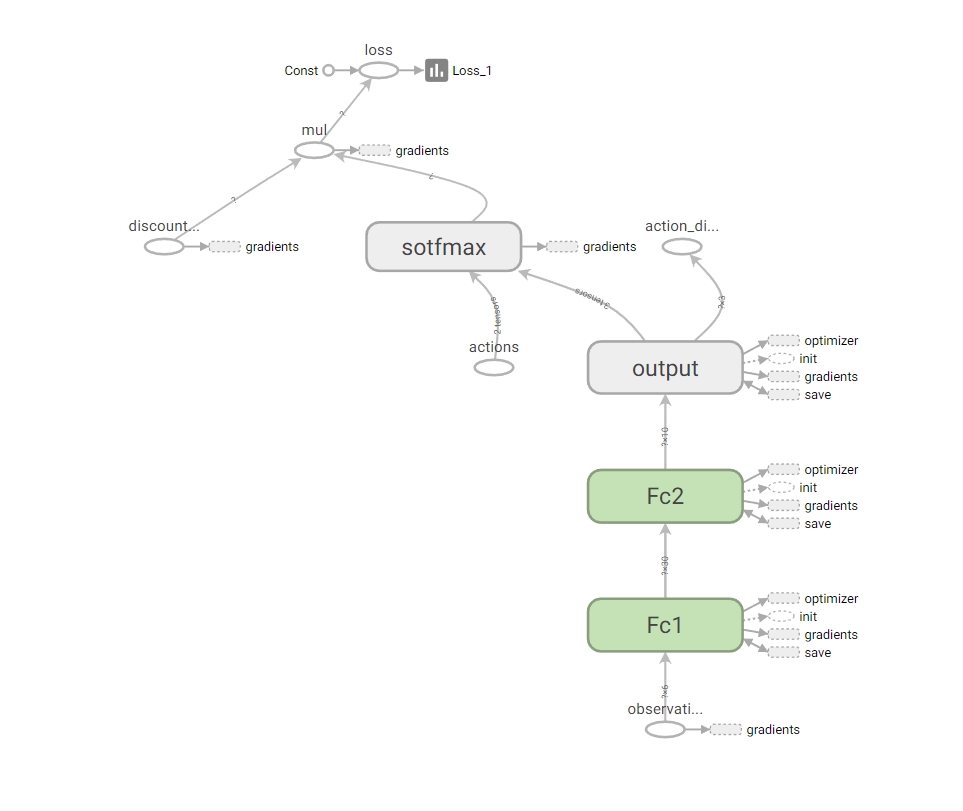

In [ ]:
#creamos una clase que contiene nuestra estructura de red neuronal
#Variables de entrada, 3 capas de nueronas, una funcion softmax para probabilidades y softmax crossentropy para clasificacion

class PolicyGradient():
    
    def __init__(self):
        self.observations = tf.placeholder(shape=(None,observation_size),dtype = tf.float32, name = "observations")
        self.actions = tf.placeholder(shape = (None, action_size), dtype = tf.float32, name = "actions")
        self.discounted_rewards_ = tf.placeholder(shape = (None,), dtype=tf.float32, name = "discounted_episodes_rewards")

        #usamos esta variable para visualizar en tensorboard
        self.mean_reward_ = tf.placeholder(tf.float32 , name="mean_reward")

        #3 fully connected layers
        self.fc1 = tf.layers.dense(inputs=self.observations, units=300,activation=tf.nn.relu,kernel_initializer=tf.contrib.layers.xavier_initializer(),name="Fc1")

        self.fc2 = tf.layers.dense(inputs=self.fc1, units= action_size, activation=tf.nn.relu,kernel_initializer=tf.contrib.layers.xavier_initializer(), name = "Fc2")

        self.output = tf.layers.dense(inputs=self.fc2, units = action_size, activation= None, kernel_initializer=tf.contrib.layers.xavier_initializer(), name = "output")

        self.action_distribution = tf.nn.softmax(self.output, name= "action_distribution")

        self.neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.output, labels = self.actions, name = "sotfmax")
        self.loss = tf.reduce_mean(self.neg_log_prob * self.discounted_rewards_, name = "loss") 
        
        #ADAM ES UNA VARIANTE DEL GRADIENT DESCENT
        self.train_opt = tf.train.AdamOptimizer(learning_rate,name="optimizer").minimize(self.loss)

In [16]:
#CREAMOS NUESTRA RED NEURONAL.
tf.reset_default_graph()
policy = PolicyGradient()

In [17]:
#Opcionalmente podemos usar tensorboard para ver el progreso de nuestro algoritmo
writer = tf.summary.FileWriter("/tensorboard/pg/" + env_name)

tf.summary.scalar("Loss", policy.loss)
tf.summary.scalar("Reward_mean", policy.mean_reward_)

write_op = tf.summary.merge_all()

In [18]:
allRewards = []  #las recompensas de todos los episodios
total_rewards = 0  #la suma de las recompensas de los episodios
maximumRewardRecorded = 0  #la puntuacion del episodio más alta
episode = 0

episode_states, episode_actions, episode_rewards = [],[],[] #datos del episodio una vez simulado con montecarlo

saver = tf.train.Saver()

if training:
    with tf.Session() as sess: #iniciamos una sesion en tensorflow
        sess.run(tf.global_variables_initializer())
        writer.add_graph(sess.graph)
        
        #las iteraciones para optimizar nuestra politica
        for episode in range(max_episodes):
            episodes_rewards_sum = 0
            state = env.reset()

            #simulamos hasta que se acabe el episodio
            while True:
                
                if render_env_training:
                    env.render()
                    
                #conseguimos las probabilidades de las acciones segun la politica
                action_prob_distribution = sess.run(policy.action_distribution, feed_dict = {policy.observations: state.reshape([1,observation_size])})
                action = np.random.choice(range(action_prob_distribution.shape[1]), p = action_prob_distribution.ravel())

                #realizamos esas acciones y guardamos la informacion del estado, accion y recompensa en sus respectivos arrays
                new_state, reward, done, info = env.step(action)
                    
                #guardamos la informacion importante del episodio en su sitio
                episode_states.append(state)
                action_ = np.zeros(action_size)
                action_[action] = 1
                episode_actions.append(action_)
                episode_rewards.append(reward)

                #cuando ha acabado el episodio calculamos la función de score teniendo en cuenta las recompensas
                if done:
                    episode_rewards_sum = np.sum(episode_rewards)
                    allRewards.append(episode_rewards_sum)
                    total_rewards = np.sum(allRewards)

                    mean_reward = np.divide(total_rewards,episode+1)
                    maximumRewardRecorded = np.amax(allRewards)

                    print("======================================")
                    print('Episode: ',episode)
                    print('Episode reward sum:  ', episode_rewards_sum)
                    print('Mean reward: ', mean_reward)
                    print('Maximum reward: ',maximumRewardRecorded)

                    discounted_episode_rewards = calculate_discounted_rewards(episode_rewards)

                    #pasamos los datos, calculamos gradientes y backprop
                    loss_, _ = sess.run([policy.loss, policy.train_opt], feed_dict={policy.observations: np.vstack(np.array(episode_states)),
                                                                     policy.actions: np.vstack(np.array(episode_actions)),
                                                                     policy.discounted_rewards_: discounted_episode_rewards})



                    #Le pasamos la información a tensorboard
                    summary = sess.run(write_op, feed_dict={policy.observations: np.vstack(np.array(episode_states)),
                                                            policy.actions: np.vstack(np.array(episode_actions)),
                                                            policy.discounted_rewards_: discounted_episode_rewards,
                                                            policy.mean_reward_: mean_reward})

                    writer.add_summary(summary, episode)
                    writer.flush()

                    # Reset the transition stores
                    episode_states, episode_actions, episode_rewards = [],[],[]

                    break

                state = new_state
                
            #guardamos el modelo cada 10 iteraciones
            if episode % 10 == 0:
                print("Saving Model")
                save_path = saver.save(sess, "/DeepLearning/models/" + env_name)

Episode:  0
Episode reward sum:   38.0
Mean reward:  38.0
Maximum reward:  38.0
Saving Model
Episode:  1
Episode reward sum:   22.0
Mean reward:  30.0
Maximum reward:  38.0
Episode:  2
Episode reward sum:   37.0
Mean reward:  32.333333333333336
Maximum reward:  38.0
Episode:  3
Episode reward sum:   34.0
Mean reward:  32.75
Maximum reward:  38.0
Episode:  4
Episode reward sum:   36.0
Mean reward:  33.4
Maximum reward:  38.0
Episode:  5
Episode reward sum:   23.0
Mean reward:  31.666666666666668
Maximum reward:  38.0
Episode:  6
Episode reward sum:   13.0
Mean reward:  29.0
Maximum reward:  38.0
Episode:  7
Episode reward sum:   30.0
Mean reward:  29.125
Maximum reward:  38.0
Episode:  8
Episode reward sum:   23.0
Mean reward:  28.444444444444443
Maximum reward:  38.0
Episode:  9
Episode reward sum:   17.0
Mean reward:  27.3
Maximum reward:  38.0
Episode:  10
Episode reward sum:   90.0
Mean reward:  33.0
Maximum reward:  90.0
Saving Model
Episode:  11
Episode reward sum:   13.0
Mean rew

Episode:  62
Episode reward sum:   138.0
Mean reward:  134.5079365079365
Maximum reward:  719.0
Episode:  63
Episode reward sum:   146.0
Mean reward:  134.6875
Maximum reward:  719.0
Episode:  64
Episode reward sum:   150.0
Mean reward:  134.92307692307693
Maximum reward:  719.0
Episode:  65
Episode reward sum:   127.0
Mean reward:  134.8030303030303
Maximum reward:  719.0
Episode:  66
Episode reward sum:   130.0
Mean reward:  134.73134328358208
Maximum reward:  719.0
Episode:  67
Episode reward sum:   142.0
Mean reward:  134.83823529411765
Maximum reward:  719.0
Episode:  68
Episode reward sum:   150.0
Mean reward:  135.05797101449275
Maximum reward:  719.0
Episode:  69
Episode reward sum:   117.0
Mean reward:  134.8
Maximum reward:  719.0
Episode:  70
Episode reward sum:   137.0
Mean reward:  134.83098591549296
Maximum reward:  719.0
Saving Model
Episode:  71
Episode reward sum:   116.0
Mean reward:  134.56944444444446
Maximum reward:  719.0
Episode:  72
Episode reward sum:   107.0
M

Episode:  123
Episode reward sum:   132.0
Mean reward:  133.91935483870967
Maximum reward:  719.0
Episode:  124
Episode reward sum:   179.0
Mean reward:  134.28
Maximum reward:  719.0
Episode:  125
Episode reward sum:   144.0
Mean reward:  134.35714285714286
Maximum reward:  719.0
Episode:  126
Episode reward sum:   268.0
Mean reward:  135.40944881889763
Maximum reward:  719.0
Episode:  127
Episode reward sum:   129.0
Mean reward:  135.359375
Maximum reward:  719.0
Episode:  128
Episode reward sum:   140.0
Mean reward:  135.3953488372093
Maximum reward:  719.0
Episode:  129
Episode reward sum:   164.0
Mean reward:  135.6153846153846
Maximum reward:  719.0
Episode:  130
Episode reward sum:   191.0
Mean reward:  136.0381679389313
Maximum reward:  719.0
Saving Model
Episode:  131
Episode reward sum:   246.0
Mean reward:  136.87121212121212
Maximum reward:  719.0
Episode:  132
Episode reward sum:   165.0
Mean reward:  137.08270676691728
Maximum reward:  719.0
Episode:  133
Episode reward s

Episode:  183
Episode reward sum:   255.0
Mean reward:  159.85326086956522
Maximum reward:  719.0
Episode:  184
Episode reward sum:   283.0
Mean reward:  160.51891891891893
Maximum reward:  719.0
Episode:  185
Episode reward sum:   308.0
Mean reward:  161.31182795698925
Maximum reward:  719.0
Episode:  186
Episode reward sum:   255.0
Mean reward:  161.81283422459893
Maximum reward:  719.0
Episode:  187
Episode reward sum:   233.0
Mean reward:  162.19148936170214
Maximum reward:  719.0
Episode:  188
Episode reward sum:   272.0
Mean reward:  162.7724867724868
Maximum reward:  719.0
Episode:  189
Episode reward sum:   300.0
Mean reward:  163.49473684210525
Maximum reward:  719.0
Episode:  190
Episode reward sum:   255.0
Mean reward:  163.9738219895288
Maximum reward:  719.0
Saving Model
Episode:  191
Episode reward sum:   274.0
Mean reward:  164.546875
Maximum reward:  719.0
Episode:  192
Episode reward sum:   267.0
Mean reward:  165.0777202072539
Maximum reward:  719.0
Episode:  193
Epis

Episode:  243
Episode reward sum:   111.0
Mean reward:  180.16803278688525
Maximum reward:  719.0
Episode:  244
Episode reward sum:   109.0
Mean reward:  179.87755102040816
Maximum reward:  719.0
Episode:  245
Episode reward sum:   115.0
Mean reward:  179.6138211382114
Maximum reward:  719.0
Episode:  246
Episode reward sum:   117.0
Mean reward:  179.36032388663966
Maximum reward:  719.0
Episode:  247
Episode reward sum:   113.0
Mean reward:  179.09274193548387
Maximum reward:  719.0
Episode:  248
Episode reward sum:   125.0
Mean reward:  178.87550200803213
Maximum reward:  719.0
Episode:  249
Episode reward sum:   146.0
Mean reward:  178.744
Maximum reward:  719.0
Episode:  250
Episode reward sum:   157.0
Mean reward:  178.65737051792829
Maximum reward:  719.0
Saving Model
Episode:  251
Episode reward sum:   177.0
Mean reward:  178.65079365079364
Maximum reward:  719.0
Episode:  252
Episode reward sum:   188.0
Mean reward:  178.68774703557312
Maximum reward:  719.0
Episode:  253
Episo

KeyboardInterrupt: 

# PROBEMOS NUESTRO MODELO

In [ ]:

with tf.Session() as sess:
    #cargamos nuestro modelo
    saver = tf.train.import_meta_graph("/DeepLearning/models/" + env_name + ".meta")
    saver.restore(sess, tf.train.latest_checkpoint("/DeepLearning/models"))
    
    #lo inicializamos
    sess.run(tf.global_variables_initializer())

    #obtenemos de el la probabilidad de realizar una accion hasta que se acaba el episodio. Esta vez sin aprender.
    for i in range(300):
        state = env.reset()
        episode_score = 0
        env.render()
        action_prob_distribution = sess.run(policy.action_distribution, feed_dict = {policy.observations: state.reshape([1,observation_size])})
        action = np.random.choice(range(action_prob_distribution.shape[1]), p = action_prob_distribution.ravel())

        new_state, reward, done,_ = env.step(action)
        episode_score += reward
        
        while not done:
            env.render()
            action_prob_distribution = sess.run(policy.action_distribution, feed_dict = {policy.observations: state.reshape([1,observation_size])})
            action = np.random.choice(range(action_prob_distribution.shape[1]), p = action_prob_distribution.ravel())
            new_state, reward, done,_ = env.step(action)
            episode_score += reward
        
        print("Score for episode ", i , " :", episode_score)
    
    env.close()
            
        
        